In [1]:
# importing sys
import sys
sys.path.insert(0, '/home/ferqui/Work/dynapse-simulator')

In [2]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

from models.TorchModel import *

torch.autograd.set_detect_anomaly(True)

timestep = 0.1 * 1e-3

In [3]:
# Parameters
input_type   = 'regular' # 'regular', 'poisson' or 'cosine' (Default: poisson)
pulse_start  = 0         # second - Start time of input (Default: 0)
pulse_stop   = 1         # second - Stop time of input (Default: 5)
inp_duration = 0.1         # second - Simulation duration (Default: 5)
rate         = 100       # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine) 
##################

if input_type == 'regular':
    
    spikes = torch.zeros(int(inp_duration/timestep))
    dt = int((1/timestep)/rate)
    spikes[pulse_start*int(1/timestep):pulse_stop*int(1/timestep):dt] = 1.0

if input_type == 'poisson':

    prob = rate * 1e-3
    mask = torch.rand(inp_duration*1000)
    spikes = torch.zeros(inp_duration*1000)
    spikes[mask < prob] = 1.0
    spikes[:pulse_start*1000]=0
    spikes[pulse_stop*1000:]=0

if input_type == 'cosine':
    
    spikes = torch.zeros(inp_duration*1000)
    time = torch.linspace(0, inp_duration, inp_duration*1000)
    co = np.cos(2 * np.pi * rate * time)
    mask = 20 * torch.rand(inp_duration*1000)
    spikes[mask < co] = 1.0
    spikes[:pulse_start*1000]=0
    spikes[pulse_stop*1000:]=0

input = spikes.unsqueeze(1).cuda()


In [4]:
model = AdexLIF(1).cuda()
model.dt = timestep
model.weight_nmda.data = torch.ones(1).cuda() * 0
model.weight_ampa.data = torch.ones(1).cuda() * 3
model.weight_gaba_a.data = torch.ones(1).cuda() * 0
model.weight_gaba_b.data = torch.ones(1).cuda() * 0
optimizer = torch.optim.Adamax(model.parameters(), lr=5e-2, betas=(0.99, 0.999))

In [5]:
def train(model, input, optimizer):
    for epoch in range(10):
        loss_out = 0
        model.state = model.init_state(input[0])
        for t in range(input.shape[0]):
            S = model(input_ampa=input[t])
            loss_out += S
        loss = torch.mean((loss_out - 4)**2)

        optimizer.zero_grad()
        loss.backward()
        print(str(loss_out.data) + " " + str(model.Isoma_th.data) + " " + str(model.weight_ampa.data) + " " + str(model.weight_ampa.grad))
        optimizer.step()
            

In [6]:
@torch.no_grad()
def test(model, input):
    output = []
    output_ampa = [] 
    output_Isoma = [] 
    model.state = model.init_state(input[0])
    for t in range(input.shape[0]):
        output_ampa.append(model.state.Iampa.cpu())
        output_Isoma.append(model.state.Isoma_mem.cpu())
        S = model(input_ampa=input[t])
        output.append(S.cpu())
    output = torch.stack(output, dim=1)
    output_ampa = torch.stack(output_ampa, dim=1)
    output_Isoma= torch.stack(output_Isoma, dim=1)

    return output, output_ampa, output_Isoma

In [7]:
for n, p in model.named_parameters():
    if p.requires_grad: print(n)

weight_nmda
weight_ampa
weight_gaba_a
weight_gaba_b


In [8]:
output_before, output_ampa_before, output_Isoma_before = test(model, input)
train(model, input, optimizer)
output_after, output_ampa_after, output_Isoma_after = test(model, input)

tensor([[3.]], device='cuda:0') tensor([2.0000e-09], device='cuda:0') tensor([3.], device='cuda:0') tensor([-8.1810e-07], device='cuda:0')
tensor([[3.]], device='cuda:0') tensor([2.0000e-09], device='cuda:0') tensor([3.0494], device='cuda:0') tensor([-7.9988e-07], device='cuda:0')
tensor([[3.]], device='cuda:0') tensor([2.0000e-09], device='cuda:0') tensor([3.0983], device='cuda:0') tensor([-7.8978e-07], device='cuda:0')
tensor([[3.]], device='cuda:0') tensor([2.0000e-09], device='cuda:0') tensor([3.1468], device='cuda:0') tensor([-7.8343e-07], device='cuda:0')
tensor([[3.]], device='cuda:0') tensor([2.0000e-09], device='cuda:0') tensor([3.1951], device='cuda:0') tensor([-7.7413e-07], device='cuda:0')
tensor([[3.]], device='cuda:0') tensor([2.0000e-09], device='cuda:0') tensor([3.2432], device='cuda:0') tensor([-7.6987e-07], device='cuda:0')
tensor([[3.]], device='cuda:0') tensor([2.0000e-09], device='cuda:0') tensor([3.2911], device='cuda:0') tensor([-7.6584e-07], device='cuda:0')
ten

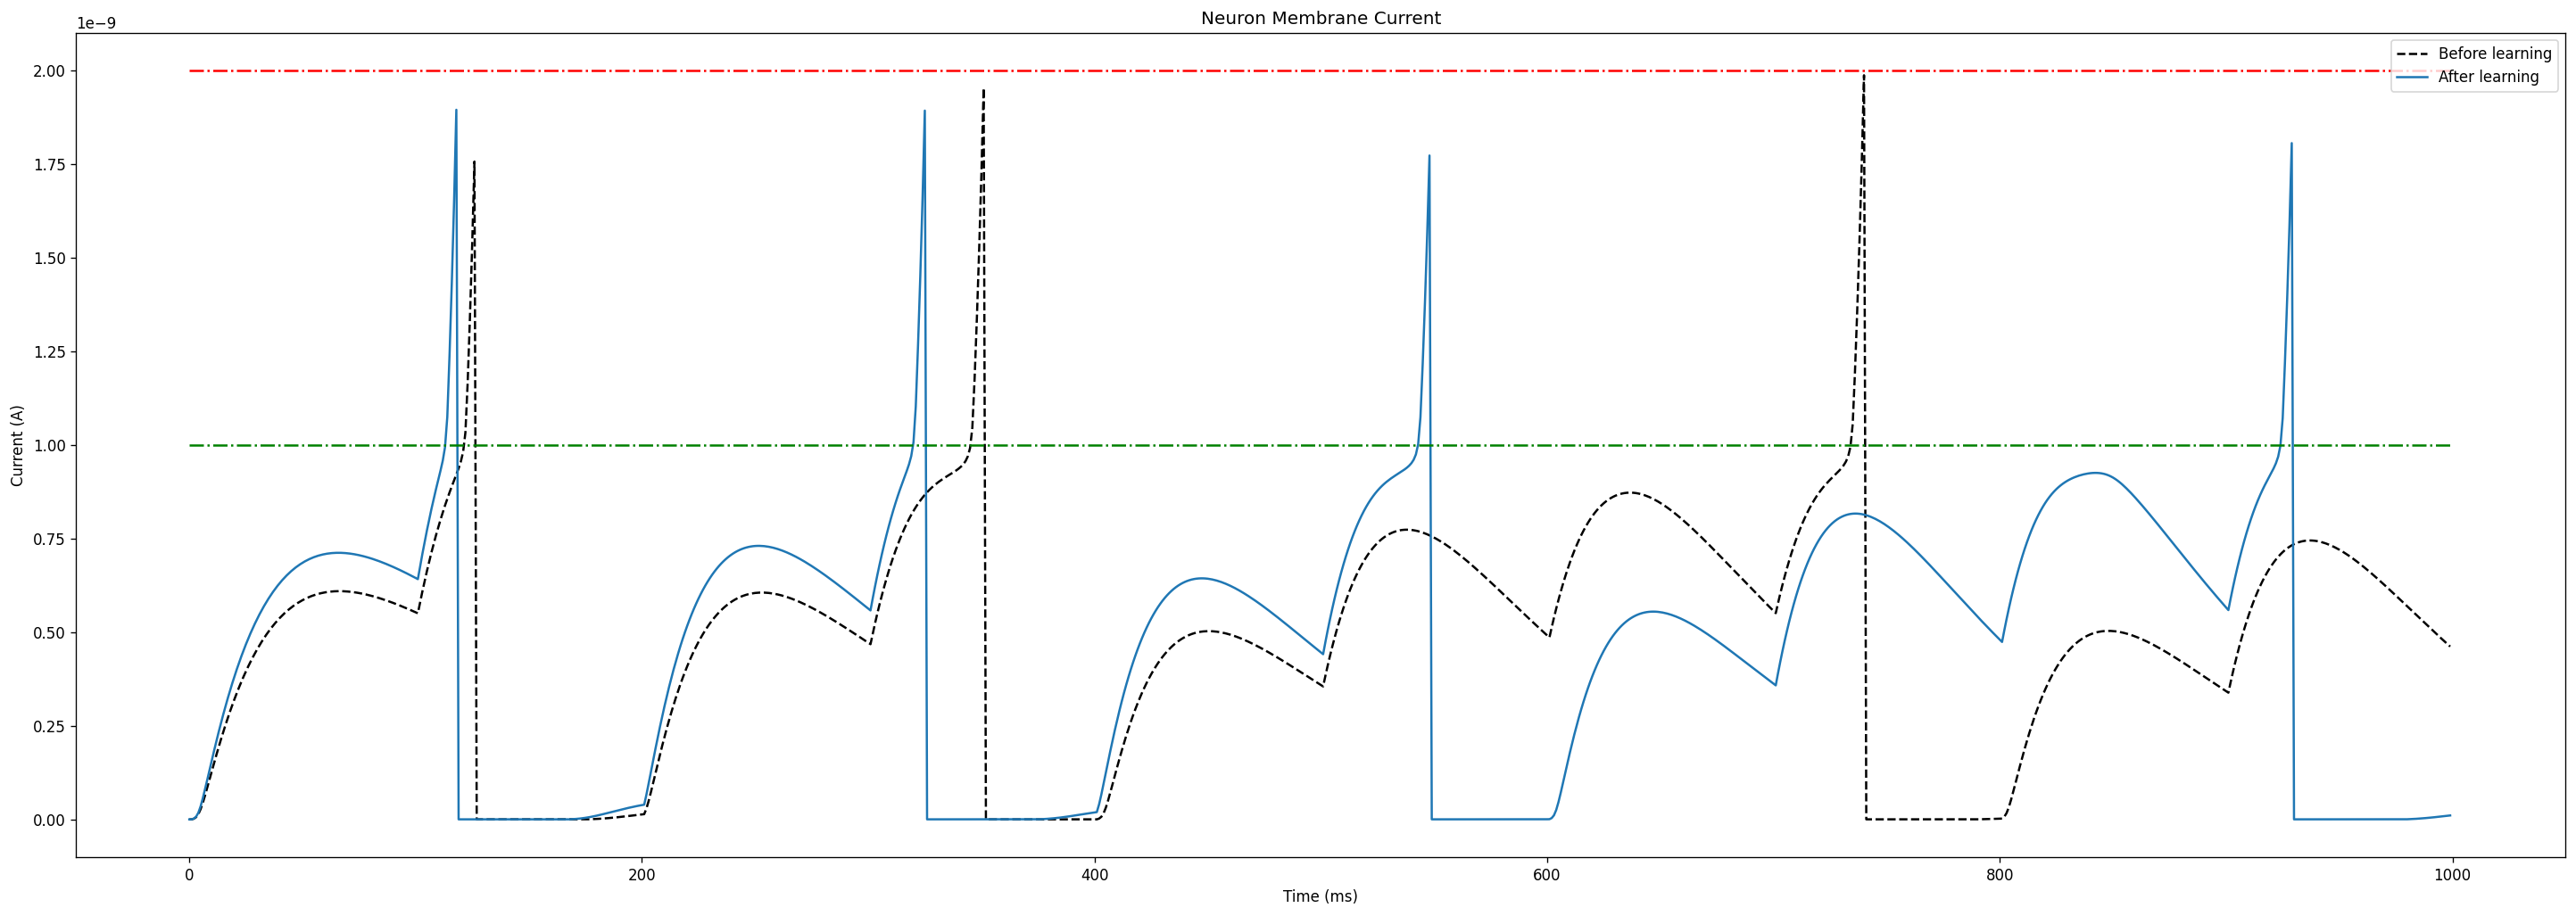

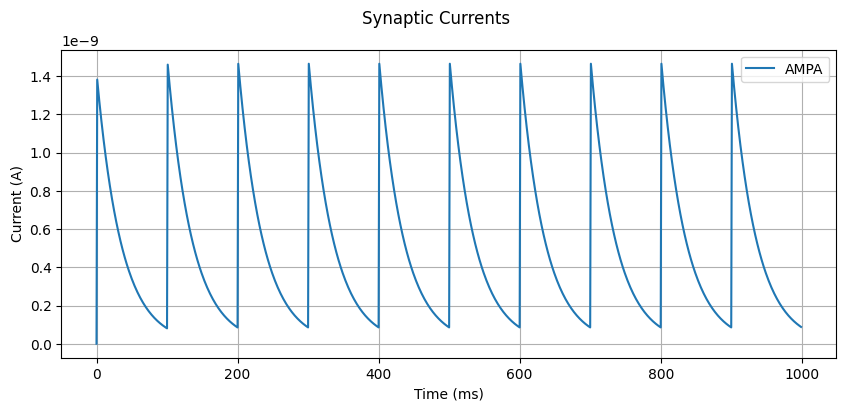

In [9]:
tstart = int(00 * (ms/timestep)) # ms 
tend   = int(100 * (ms/timestep)) # ms
##################

# Plotting
plt.figure(figsize=(30,10),dpi=120)
plt.subplots_adjust(hspace=2)

plt.subplot(111)
plt.plot(output_Isoma_before[0].detach(), '--k')
plt.plot(output_Isoma_after[0].detach())
plt.hlines(y=model.Isoma_th.detach().cpu().numpy(), xmin=0, xmax=int(inp_duration/timestep), color='r', linestyles='-.')
plt.hlines(y=model.Isoma_pfb_th.detach().cpu().numpy(), xmin=0, xmax=int(inp_duration/timestep), color='g', linestyles='-.')
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.legend(['Before learning', 'After learning'])
plt.xlabel('Time (ms)')

fig, ax1 = plt.subplots(1, 1,figsize=(10,4))
fig.suptitle('Synaptic Currents')

ax1.plot(output_ampa_after[0][tstart:tend].detach(), linewidth=1.5)
ax1.legend(['AMPA'])
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)
plt.show()